#### DATA ENGINEERING PLATFORMS FINAL PROJECT
#### Analysis on Life Expectancy and Social Economic Status in US States


- There are very diverse estimates on life expectancy for US citizens based on different silo demographic variables e.g. gender, race, state, income bracket, mortality. 
- Our goal is to help government agencies to integrate life expectancy and refine the estimates for the overall person's life expectancy using regression analysis to identify which variable is most sensitive to life expectancy
- Using the model, we will try estimate overall person's life expectancy for the period of 2008-2017

#### Install packages and import libraries

In [1]:
#!pip install pymysql  

In [1]:
import pymysql
import pandas as pd  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp
import scipy.stats
from scipy.stats import spearmanr
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#### Import libraries

# Database connection and function to query via select

In [2]:
# Create a function for easily querying data.
def qry(sql):

    # Open database connection to Google Cloud Platform
    connection = pymysql.connect("34.68.61.233","vince","root","lifeexpdw" )
    df = pd.read_sql(sql, connection)

    # disconnect from server
    connection.commit()
    connection.close()
    
    # return data.
    return df

In [3]:
#creating another function for executing non-SELECT functions
def execute(sql):

    # Open database connection
    connection = pymysql.connect("34.68.61.233","vince","root","lifeexpdw" )
    my_database = connection.cursor()
    df = my_database.execute(sql)
    
    # disconnect from server
    connection.commit()
    connection.close()
    
    # return data.
    return df

####  Select lifeexpdw database.

In [4]:
sql = "SHOW DATABASES;"
qry(sql)

,Database
0,information_schema
1,lifeexpdw
2,mysql
3,performance_schema
4,sys


In [5]:
execute("USE lifeexpdw;")

0

#### Show all tables in the sakila database.

In [6]:
sql = "SHOW TABLES;"
qry(sql)

,Tables_in_lifeexpdw
0,dim_gender
1,dim_income
2,dim_race
3,dim_state
4,dim_year
5,fact_personlifeexp


# Show each of the columns along with their data types for each table

In [7]:
sql = "DESCRIBE dim_year; "
qry(sql)

,Field,Type,Null,Key,Default,Extra
0,year,int(10),NO,PRI,None,


In [8]:
sql = "DESCRIBE dim_gender; "
qry(sql)

,Field,Type,Null,Key,Default,Extra
0,genderid,int(2),NO,PRI,None,
1,gendername,varchar(10),NO,,None,
2,gender_lifeexp,"decimal(5,2)",YES,,None,
3,mortality,"decimal(5,2)",YES,,None,
4,year,int(10),NO,PRI,None,
5,stateid,int(2),NO,PRI,None,


In [9]:
sql = "DESCRIBE dim_income; "
qry(sql)

,Field,Type,Null,Key,Default,Extra
0,incomeid,int(2),NO,PRI,None,
1,incomebracket,varchar(20),NO,,None,
2,income_lifeexp,"decimal(5,2)",YES,,None,
3,percentagepopulation,"decimal(5,2)",YES,,None,
4,year,int(10),NO,PRI,None,
5,stateid,int(2),NO,PRI,None,


In [10]:
sql = "DESCRIBE dim_race; "
qry(sql)

,Field,Type,Null,Key,Default,Extra
0,raceid,int(2),NO,PRI,None,
1,racename,varchar(10),NO,,None,
2,race_lifeexp,"decimal(5,2)",YES,,None,
3,year,int(10),NO,PRI,None,
4,genderid,int(2),NO,PRI,None,


In [11]:
sql = "DESCRIBE dim_state; "
qry(sql)

,Field,Type,Null,Key,Default,Extra
0,stateid,int(2),NO,PRI,None,
1,state_abbrv,varchar(2),NO,,None,
2,statename,varchar(20),NO,,None,
3,population,int(9),YES,,None,
4,hospitals,int(4),YES,,None,
5,expenditure,bigint(30),YES,,None,
6,state_lifeexp,"decimal(5,2)",YES,,None,
7,uninsuredrate,"decimal(5,2)",YES,,None,
8,year,int(10),NO,PRI,None,
9,expend_per_cap,bigint(30),YES,,None,


In [12]:
sql = "DESCRIBE fact_personlifeexp; "
qry(sql)
# we will be finding the best estimate for person_lifeexp

,Field,Type,Null,Key,Default,Extra
0,personid,int(10),NO,PRI,None,auto_increment
1,genderid,int(2),NO,MUL,None,
2,raceid,int(2),NO,MUL,None,
3,stateid,int(2),NO,MUL,None,
4,incomeid,int(2),NO,MUL,None,
5,person_lifeexp,float,YES,,None,
6,year,int(10),NO,MUL,None,


# Query data for predicting life expectancy analysis

1. We started with doing a simple average of life expentacy figures from dim_state, dim_income and dim_gender to estimate person's overall life expectancy estimates
2. Goal is better predict's person's life expectancy through regression analysis on the key predictors

List of variables to be analyzed: 
1. Income bracket
2. Race
3. State
4. Gender
5. Percentage of population in a income bracket
6. Expenditure per capital income
7. Number of hospitals per 100k population
8. Uninsured rate by state

In [13]:
sql = "SELECT g.genderid, r.raceid, s.stateid,   \
        i.incomeid, s.uninsuredrate, g.mortality, y.year,  \
        (g.gender_lifeexp+i.income_lifeexp+r.race_lifeexp+s.state_lifeexp)/4 as avg_lifeexp, \
        i.percentagepopulation as percentpopincome, s.expend_per_cap as expend_per_cap,\
        s.hospitals_per_100k    \
    FROM dim_year y       \
        INNER JOIN dim_state s ON s.year = y.year           \
        INNER JOIN dim_income i ON i.stateid = s.stateid    \
        INNER JOIN dim_gender g ON g.stateid = i.stateid    \
        INNER JOIN dim_race r ON g.genderid = r.genderid    \
        WHERE y.year >= '2008'                  \
    GROUP BY g.genderid, r.raceid, s.stateid, i.incomeid, s.uninsuredrate, y.year;"

lifeexpfact = qry(sql)
lifeexpfact.head()

,genderid,raceid,stateid,incomeid,uninsuredrate,mortality,year,avg_lifeexp,percentpopincome,expend_per_cap,hospitals_per_100k
0,1,1,1,1,12.91,14.86,2008,78.0075,0.0,6325.0,2.31
1,1,1,1,1,13.39,14.86,2009,78.0450,0.0,6325.0,2.27
2,1,1,1,1,14.15,14.86,2010,78.1075,0.0,6421.0,2.16
3,1,1,1,1,13.84,14.86,2011,78.1075,0.0,6541.0,2.09
4,1,1,1,1,12.93,14.86,2012,78.1250,0.0,6821.0,1.98


In [63]:
#save the file at local for ease of reading data for analysis
lifeexpfact.to_csv("lifeexpfact_mortality.csv")

In [15]:
lifeexpfact.shape

(16320, 11)

#### Confirming missing values to spilt data into train and test

In [16]:
lifeexpfact.isnull().sum()

genderid                 0
raceid                   0
stateid                  0
incomeid                 0
uninsuredrate           64
mortality              320
year                     0
avg_lifeexp           4320
percentpopincome         0
expend_per_cap           0
hospitals_per_100k       0
dtype: int64

In [17]:
#there are two states (state id : 10, 56) with NULL values for uninsured rate year 2014 and 2017 
# due to data availability
# impute NULL uninsuredrate with projection using dim_state data
lifeexpfact[lifeexpfact.iloc[:,5].isnull()==True].tail()

,genderid,raceid,stateid,incomeid,uninsuredrate,mortality,year,avg_lifeexp,percentpopincome,expend_per_cap,hospitals_per_100k
13275,2,4,11,4,6.27,NaN,2013,NaN,0.25,11466.00,1.64
13276,2,4,11,4,4.99,NaN,2014,NaN,0.25,11944.00,1.62
13277,2,4,11,4,3.61,NaN,2015,NaN,0.25,12311.34,1.59
13278,2,4,11,4,3.68,NaN,2016,NaN,0.25,12689.99,1.56
13279,2,4,11,4,3.63,NaN,2017,NaN,0.25,13080.27,1.54


#### Imputing null values in column uninsured rate with values -999

In [18]:
# since there is only 64 missing and only from 2 states and 2years, we fill NA with -999 for analysis
lifeexpfact[['uninsuredrate']] = lifeexpfact[['uninsuredrate']].fillna(value=-999)
lifeexpfact.isnull().sum()

genderid                 0
raceid                   0
stateid                  0
incomeid                 0
uninsuredrate            0
mortality              320
year                     0
avg_lifeexp           4320
percentpopincome         0
expend_per_cap           0
hospitals_per_100k       0
dtype: int64

# Split train and test datasets for lifeexpfact
by splitting null person_lifeexp with non-nulls

In [19]:
train_lifeexpfact = lifeexpfact.dropna()
test_lifeexpfact = lifeexpfact[pd.isnull(lifeexpfact).any(axis=1)]

In [20]:
print(train_lifeexpfact.shape, test_lifeexpfact.shape)

(12000, 11) (4320, 11)


# Summary statistics on train data

1. Female has higher life expectancy and male in the US

In [21]:
by_gender = train_lifeexpfact[['genderid','avg_lifeexp']].groupby('genderid').mean()
by_gender.sort_values(by=['avg_lifeexp'], ascending=False)
#gender 1 is female and gender 2 is male


,avg_lifeexp
genderid,
1,80.104537
2,76.810203


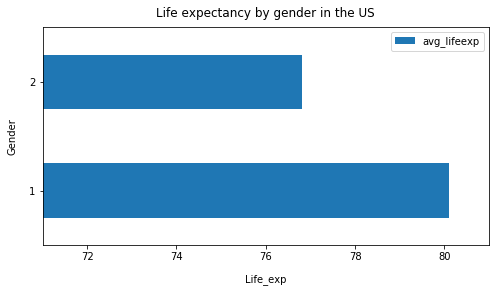

In [22]:
rcParams['figure.figsize'] = 8, 4
by_gender.plot(kind='barh',figsize= (8,4),rot=0)
plt.xlabel("Life_exp", labelpad=12)
plt.xlim(71,81)
plt.ylabel("Gender", labelpad=12)
plt.title("Life expectancy by gender in the US", y=1.02)
plt.show()

2. Hispanics and white have higher life expectancy in the US

In [23]:
by_race = train_lifeexpfact[['raceid','avg_lifeexp']].groupby('raceid').mean()
by_race.sort_values(by=['avg_lifeexp'], ascending=False)
#raceid 1 = white, raceid 2 = black, raceid 3 = hispanics, raceid 4 = asian
# asian has no data heredue to null values

,avg_lifeexp
raceid,
3,79.23237
1,78.71987
2,77.41987


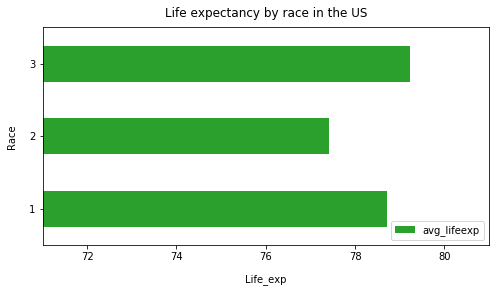

In [24]:
rcParams['figure.figsize'] = 8, 4
by_race.plot(kind='barh',figsize= (8,4),rot=0, color ='tab:green')
plt.xlabel("Life_exp", labelpad=12)
plt.xlim(71,81)
plt.ylabel("Race", labelpad=12)
plt.title("Life expectancy by race in the US", y=1.02)
plt.show()

3. Americans who earned from than $75k a year have higher life expentancy

In [25]:
by_income = train_lifeexpfact[['incomeid','avg_lifeexp']].groupby('incomeid').mean()
by_income.sort_values(by=['avg_lifeexp'], ascending=False)
# 1 refers to annual income =< $25,000, 2 = $25,001-%50,000, 3= $50,001 to $75,000, 4= $75,001 and above

,avg_lifeexp
incomeid,
4,79.30017
3,78.81037
2,78.31347
1,77.40547


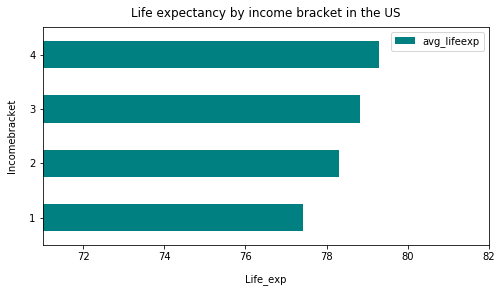

In [26]:
rcParams['figure.figsize'] = 8, 4
by_income.plot(kind='barh',figsize= (8,4),rot=0, color ='teal')
plt.xlabel("Life_exp", labelpad=12)
plt.xlim(71,82)
plt.ylabel("Incomebracket", labelpad=12)
plt.title("Life expectancy by income bracket in the US", y=1.02)
plt.show()
# 1 refers to annual income =< $25,000, 2 = $25,001-%50,000, 3= $50,001 to $75,000, 4= $75,001 and above

4. Minessota, Utah and Vermont have the highest life expectancy compared to other states in the US.

In [27]:
by_state = train_lifeexpfact[['stateid','avg_lifeexp']].groupby('stateid').mean()
by_state1 = by_state.sort_values(by=['avg_lifeexp'], ascending=False).head()
by_state1

,avg_lifeexp
stateid,
27,79.655500
49,79.597375
50,79.453250
15,79.416125
8,79.411250


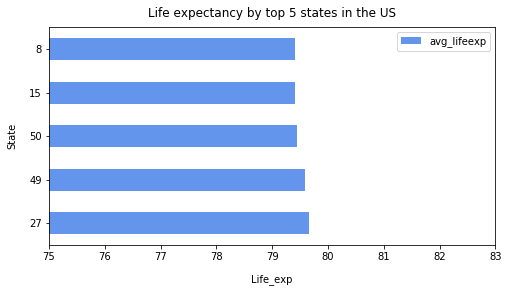

In [28]:
rcParams['figure.figsize'] = 8, 4
by_state1.plot(kind='barh',figsize= (8,4),rot=0, color ='cornflowerblue')
plt.xlabel("Life_exp", labelpad=12)
plt.xlim(75,83)
plt.ylabel("State", labelpad=12)
plt.title("Life expectancy by top 5 states in the US", y=1.02)
plt.show()

5. Average life expectancy for all Americans is highest in 2013 and 2014 for the period of 2008-2017

In [29]:
by_year = train_lifeexpfact[['year','avg_lifeexp']].groupby('year').mean()
by_year = pd.DataFrame(by_year)
by_year

,avg_lifeexp
year,
2008,78.36305
2009,78.40680
2010,78.47120
2011,78.47645
2012,78.50510
2013,78.51340
2014,78.50900
2015,78.46765
2016,78.43445


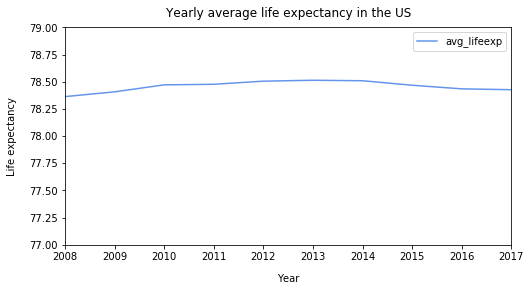

In [30]:
rcParams['figure.figsize'] = 8, 4
by_year.plot(kind='line',figsize= (8,4),rot=0, color ='cornflowerblue')
plt.xlabel("Year", labelpad=12)
plt.ylabel("Life expectancy", labelpad=12)
plt.ylim(77.0,79.0)
plt.title("Yearly average life expectancy in the US", y=1.02)
plt.show()

# Correlation matrix (Spearman's)

Spearman's correlation is used to check the correlations among predictors for life expectancy
Due to nominal and non-parametric features, Spearman's correlation is pursued

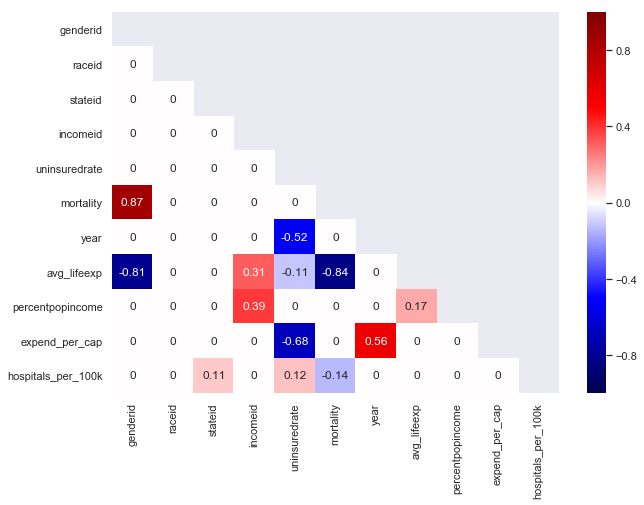

In [31]:
corr = train_lifeexpfact.corr(method = "spearman")
corr[np.abs(corr)<.1] = 0
sns.set(rc={'figure.figsize':(10,7)})
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
sns.heatmap(corr, mask=mask, cmap="seismic", annot=True, vmin=-1, vmax=1)

Seems like average overall lifeexpentancy has highly negative correlation with mortality and gender (life expentancy, most likely, increases if mortality risk decreases and gender gap in life expectancy decreases) and slight correlation for income bracket (which infers life expentancy is more likely to increase with income bracket). Correlation is very insignifcant for race and state. Interest to note that expenditure per capital income for US citizens has been positively correlated with year and negatively correlated with uninsured rate (which may infer 

# Ordinary Least Squares Regression Model

In [32]:
#reorder the columns
lifeexpfact_metadata = train_lifeexpfact[['year', 'stateid', 'raceid', 'genderid', 'incomeid', 
                                    'uninsuredrate','percentpopincome', 'expend_per_cap', 
                                    'hospitals_per_100k','mortality','avg_lifeexp']]

In [33]:
lifeexpfact_metadata.shape

(12000, 11)

In [34]:
# select features
X1 = lifeexpfact_metadata[['year', 'stateid', 'raceid', 'genderid', 'incomeid', 
                                    'uninsuredrate','percentpopincome', 'expend_per_cap', 
                                    'hospitals_per_100k','mortality']].astype(float)
#to include constant 1
X= sm.add_constant(X1)
X.head()

,const,year,stateid,raceid,genderid,incomeid,uninsuredrate,percentpopincome,expend_per_cap,hospitals_per_100k,mortality
0,1.0,2008.0,1.0,1.0,1.0,1.0,12.91,0.0,6325.0,2.31,14.86
1,1.0,2009.0,1.0,1.0,1.0,1.0,13.39,0.0,6325.0,2.27,14.86
2,1.0,2010.0,1.0,1.0,1.0,1.0,14.15,0.0,6421.0,2.16,14.86
3,1.0,2011.0,1.0,1.0,1.0,1.0,13.84,0.0,6541.0,2.09,14.86
4,1.0,2012.0,1.0,1.0,1.0,1.0,12.93,0.0,6821.0,1.98,14.86


In [35]:
# select target variable
Y = lifeexpfact_metadata[['avg_lifeexp']].astype(float)
Y.head()

,avg_lifeexp
0,78.0075
1,78.0450
2,78.1075
3,78.1075
4,78.1250


## Fit linear regression model using statsmodel

In [36]:
# fit the linear regression model
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            avg_lifeexp   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     6116.
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:56:43   Log-Likelihood:                -15091.
No. Observations:               12000   AIC:                         3.020e+04
Df Residuals:                   11989   BIC:                         3.029e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                174.5396      6.629     26.329      0.000     161.545     187.534
year                  -0.0448      0.003    -13.547      0.000      -0.051      -0.038
stateid                0.0035      0.001      7.039      0.000       0.003       0.005
raceid                 0.2563      0.010     26.921      0.000       0.238       0.275
genderid               1.0378      0.055     18.876      0.000       0.930       1.146
incomeid               0.6145      0.007     88.330      0.000       0.601       0.628
uninsuredrate       6.393e-05      0.000      0.521      0.602      -0.000       0.000
percentpopincome       0.3949      0.031     12.607      0.000       0.334       0.456
expend_per_cap         0.0002   7.13e-06     25.472      0.000       0.000       0.000
hospitals_per_100k    -0.0847      0.006    -13.338      0.000      -0.097      -0.072
mortality             -0.6240      0.008    -82.145      0.000      -0.639      -0.609
==============================================================================
Omnibus:                     1351.503   Durbin-Watson:                   0.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              866.295
Skew:                          -0.537   Prob(JB):                    7.70e-189
Kurtosis:                       2.240   Cond. No.                     7.03e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.03e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Results show gender, income bracket and mortality are more sensitive features than the others. And R squared is high and is closed to R squared adjusted

# Selection of important features for this model

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

Check the ranking of the features using principal component analysis, recursive feature elimination and Lasso model

## Let's use principal component analysis to rank the features

In [39]:
#principal component analysis (PCA)
from sklearn.decomposition import PCA
# set components to 5
pca = PCA(n_components=5)
pca.fit(X1) #fit pca model

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [40]:
# print out pca's 5 factor loadings
print(pca.components_)

[[ 1.20631506e-03  6.13403000e-04 -4.38386706e-19  2.39773661e-11
  -3.49138593e-17 -6.62847767e-03 -5.55848655e-09  9.99977113e-01
   6.58271588e-05  2.48470064e-05]
 [ 1.15195549e-03  4.08720895e-03  1.11022312e-16 -2.07235758e-08
   1.26937640e-12 -9.99968961e-01  4.50907694e-07 -6.63230369e-03
  -2.36382500e-04 -4.79414283e-05]
 [ 5.69190439e-03 -9.99922927e-01 -4.71128207e-21  6.73576664e-06
  -3.06474884e-11 -4.08194747e-03 -6.56727814e-07  5.80093061e-04
  -1.01908585e-02  9.43643486e-04]
 [ 5.21337232e-03 -1.29365268e-03 -6.74807438e-16 -1.30109167e-01
   3.28533304e-09  3.91252238e-05  3.55161450e-06  1.68800184e-05
   3.80026590e-02 -9.90756553e-01]
 [ 9.95923014e-01  6.58171453e-03 -2.17707760e-16  5.49475818e-04
   1.68439697e-08  1.20327686e-03  6.56160014e-06 -1.19160801e-03
  -8.99329609e-02  1.71025517e-03]]


Now that we have the factor loadings, we would like to know how many components/loadings required to explain the data

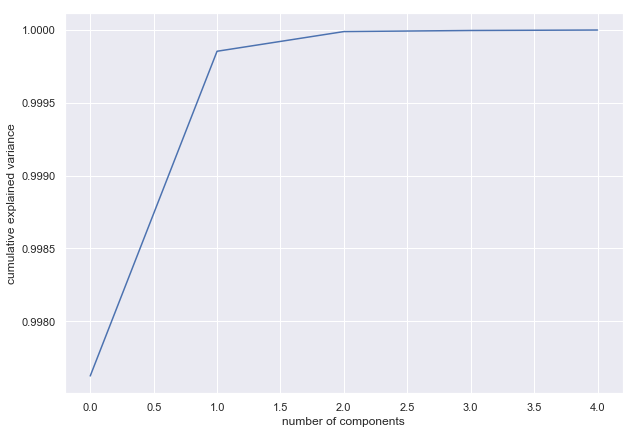

In [41]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

The curve shows the most of the variance of the data can explained with 2 components

In [42]:
# print out the first and second component
col = pd.DataFrame(X1.columns, columns=['features'])
pca1 = pd.DataFrame(pca.components_[0], columns =['pca1 loadings'])
pca2 = pd.DataFrame(pca.components_[1], columns =['pca2 loadings'])
feature_pca = pd.concat([col,pca1,pca2],axis=1)
feature_pca

,features,pca1 loadings,pca2 loadings
0,year,1.206315e-03,1.151955e-03
1,stateid,6.134030e-04,4.087209e-03
2,raceid,-4.383867e-19,1.110223e-16
3,genderid,2.397737e-11,-2.072358e-08
4,incomeid,-3.491386e-17,1.269376e-12
5,uninsuredrate,-6.628478e-03,-9.999690e-01
6,percentpopincome,-5.558487e-09,4.509077e-07
7,expend_per_cap,9.999771e-01,-6.632304e-03
8,hospitals_per_100k,6.582716e-05,-2.363825e-04
9,mortality,2.484701e-05,-4.794143e-05


In [43]:
# print out the PCA factor score
X_pca = pca.transform(X1)
X_pca = pd.DataFrame(X_pca, columns =['pca1','pca2','pca3','pca4','pca5'])
X_pca= sm.add_constant(X_pca)
X_pca.head()

,const,pca1,pca2,pca3,pca4,pca5
0,1.0,-1563.462453,4.845280,27.359258,2.774068,-2.815493
1,1.0,-1563.464431,4.366456,27.363398,2.777780,-1.815396
2,1.0,-1467.470466,2.970957,27.422798,2.780463,-0.923060
3,1.0,-1347.469956,2.486239,27.500080,2.785030,-0.064207
4,1.0,-1067.469133,1.540344,27.673033,2.790754,0.606863


In [44]:
#reset index to run model with X_pca as predictors and Y2 as target variable
Y2 = Y.reset_index()
Y2 = Y2[['avg_lifeexp']]

In [45]:
# fit linear model with PCA factor scores as predictors
model = sm.OLS(Y2,X_pca)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            avg_lifeexp   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     5838.
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:56:57   Log-Likelihood:                -18540.
No. Observations:               12000   AIC:                         3.709e+04
Df Residuals:                   11994   BIC:                         3.714e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.4574      0.010   7574.880      0.000      78.437      78.478
pca1           0.0001   7.72e-06     14.020      0.000    9.31e-05       0.000
pca2        -5.22e-05      0.000     -0.319      0.749      -0.000       0.000
pca3          -0.0035      0.001     -5.284      0.000      -0.005      -0.002
pca4           0.4798      0.003    169.981      0.000       0.474       0.485
pca5          -0.0375      0.004     -8.600      0.000      -0.046      -0.029
==============================================================================
Omnibus:                      341.083   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              242.366
Skew:                          -0.244   Prob(JB):                     2.35e-53
Kurtosis:                       2.503   Cond. No.                     1.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
#which pca ranks the highest?
# from the coefficients, pca1 and pca4 have the highest

pca4 = pd.DataFrame(pca.components_[4], columns =['pca4 loadings'])
feature_selection = pd.concat([col,pca1,pca4],axis=1)

In [47]:
feature_selection['pca1_plus_pca4'] = pca1['pca1 loadings']+pca4['pca4 loadings']
feature_selection.sort_values(ascending=False, by=['pca1_plus_pca4'])

,features,pca1 loadings,pca4 loadings,pca1_plus_pca4
7,expend_per_cap,9.999771e-01,-1.191608e-03,9.987855e-01
0,year,1.206315e-03,9.959230e-01,9.971293e-01
1,stateid,6.134030e-04,6.581715e-03,7.195118e-03
9,mortality,2.484701e-05,1.710255e-03,1.735102e-03
3,genderid,2.397737e-11,5.494758e-04,5.494758e-04
6,percentpopincome,-5.558487e-09,6.561600e-06,6.556042e-06
4,incomeid,-3.491386e-17,1.684397e-08,1.684397e-08
2,raceid,-4.383867e-19,-2.177078e-16,-2.181461e-16
5,uninsuredrate,-6.628478e-03,1.203277e-03,-5.425201e-03
8,hospitals_per_100k,6.582716e-05,-8.993296e-02,-8.986713e-02


PCA1 and 4 rank expend_per_cap first, then year, state, mortality, genderid, percentpopincome, incomeid, and raceid. Loadings > 0

## Recursive feature elimiation (wrapper method)

It is on optimization algorithm which aims to find the best performing feature subset. It repeatedly creates models and keeps aside the best or the worst performing feature at each iteration. It constructs the next model with the left features until all the features are exhausted. It then ranks the features based on the order of their elimination.

We only have 10 features from our datasets for the model but since all is important, let's check if this model requires all 10 features

Calculate optimum number of features for the model

In [54]:
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))#no of features

Optimum number of features: 10
Score with 10 features: 0.836642


Calculate optimum number of features for the model

Results show all 10 features all important

In [56]:
# use sklearn for linear regression
model.fit(X,Y)
#initializing RFE model
# RFE is recursive feature elimination
# it removes attributes and building a model on those attributes that remain according to importance
rfe = RFE(model, 10)
X_rfe = rfe.fit_transform(X,Y)

#fit data into model
model.fit(X_rfe,Y)
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True  True  True  True  True  True  True  True]
[2 1 1 1 1 1 1 1 1 1 1]


Results reveals that all features are important since first feature is just a constant number

## Lasso Method

#### RFE is giving importance to all variables. Now, let's check with Lasso model (embedded method)

Lasso can reduce model complexity and prevent over-fitting which may result from simple linear regression

In [57]:
reg = LassoCV()
reg.fit(X, Y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,Y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.194744
Best score using built-in LassoCV: 0.809230


In [58]:
print("Lasso picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 6 variables and eliminated the other 5 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

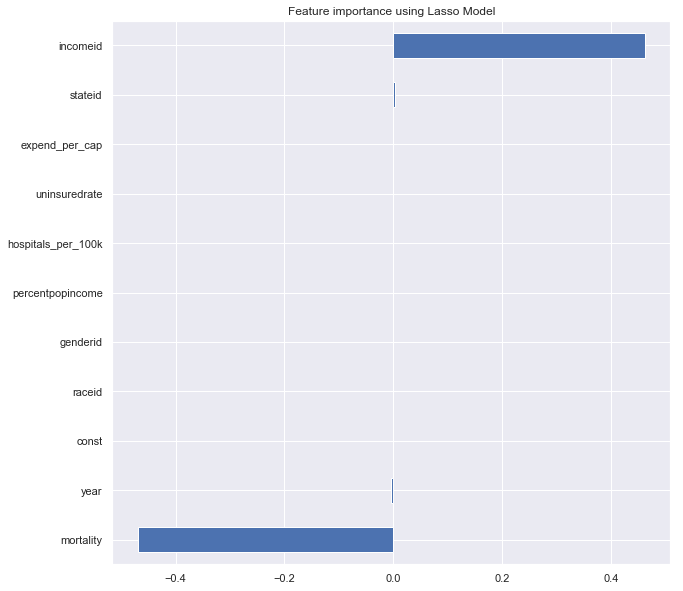

In [59]:
imp_coef = coef.sort_values()
rcParams['figure.figsize'] = (10.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [60]:
imp_coef

mortality            -0.469994
year                 -0.003444
const                 0.000000
raceid                0.000000
genderid             -0.000000
percentpopincome      0.000000
hospitals_per_100k   -0.000000
uninsuredrate         0.000030
expend_per_cap        0.000123
stateid               0.002240
incomeid              0.462305
dtype: float64

Lasso ranks mortality first, followed by income, year, state, expenditure per capital income and uninsured rate (as long as it is not 0)

#### Since Lasso selects a different features, let's fit the regression model by removing raceid, genderid, percentpopincome and hospitals

# Finalizing features selection

PCA1 and 4 rank expend_per_cap first, then year, state, mortality, genderid, percentpopincome, incomeid, and raceid. Loadings > 0

Based on the three methods used above, these are the more important features (LASSO is the more robust feature selection followed by RFE and PCA so weightage will be given to LASSO first): 
- mortality (PCA, RFE, LASSO)
- year (PCA, RFE, LASSO)
- stateid (PCA, RFE, LASSO)
- expenditure per capital income (PCA, RFE,LASSO) 
- incomeid (RFE, LASSO)
- genderid (PCA, RFE)
- percentpopincome (PCA, RFE)
- raceid (PCA, RFE)

So, uninsuredrate and hospitals per 100k will be remove from mode features

In [61]:
X2= lifeexpfact_metadata[['mortality', 'year', 'stateid', 'expend_per_cap',
                          'incomeid','genderid','percentpopincome',
                         'raceid']].astype(float)
#to include constant 1
X2= sm.add_constant(X2)
X2.head()

,const,mortality,year,stateid,expend_per_cap,incomeid,genderid,percentpopincome,raceid
0,1.0,14.86,2008.0,1.0,6325.0,1.0,1.0,0.0,1.0
1,1.0,14.86,2009.0,1.0,6325.0,1.0,1.0,0.0,1.0
2,1.0,14.86,2010.0,1.0,6421.0,1.0,1.0,0.0,1.0
3,1.0,14.86,2011.0,1.0,6541.0,1.0,1.0,0.0,1.0
4,1.0,14.86,2012.0,1.0,6821.0,1.0,1.0,0.0,1.0


# Fitting new linear model based on feature selection

In [62]:
# fit the new linear regression model
model = sm.OLS(Y,X2)
results2 = model.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            avg_lifeexp   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     7512.
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:01:18   Log-Likelihood:                -15179.
No. Observations:               12000   AIC:                         3.038e+04
Df Residuals:                   11991   BIC:                         3.044e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              162.8561      6.615     24.620      0.000     149.890     175.822
mortality           -0.5910      0.007    -81.697      0.000      -0.605      -0.577
year                -0.0391      0.003    -11.855      0.000      -0.046      -0.033
stateid              0.0027      0.001      5.448      0.000       0.002       0.004
expend_per_cap       0.0002   7.08e-06     23.786      0.000       0.000       0.000
incomeid             0.6145      0.007     87.688      0.000       0.601       0.628
genderid             0.8084      0.053     15.368      0.000       0.705       0.912
percentpopincome     0.3953      0.032     12.529      0.000       0.333       0.457
raceid               0.2563      0.010     26.725      0.000       0.237       0.275
==============================================================================
Omnibus:                     1355.214   Durbin-Watson:                   0.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              868.895
Skew:                          -0.538   Prob(JB):                    2.10e-189
Kurtosis:                       2.239   Cond. No.                     6.97e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.97e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

New linear model without features uninsured rate and and hospitals per 100k have a slightly lower Rsquared (0.834 compared to 0.836) but the standard errors are lower and coefficients are still significant.

# Converting coefficients of final model into weightage to estimate person's life expentancy in the US

In [63]:
def get_coef_table(lin_reg):
    ''' 
    Return a dataframe containing coefficients, pvalues, and the confidence intervals
    '''
    err_series = lin_reg.params - lin_reg.conf_int()[0]
    coef_df = pd.DataFrame({'varname': err_series.index.values[1:],
                            'coef': lin_reg.params.values[1:],
                            'conf_int': err_series.values[1:],
                            'pvalue': lin_reg.pvalues.round(4).values[1:]
                           })
    return coef_df

In [64]:
# to get the coefficients
coef = get_coef_table(results2)[['varname','coef']]
# converting each coefficient value into percentage of total coefficients value
total_coef = sum(abs(coef['coef']))
coef['percentage']= (abs(coef[['coef']])/total_coef)*100
coef

,varname,coef,percentage
0,mortality,-0.590985,21.827379
1,year,-0.039138,1.445529
2,stateid,0.002736,0.101034
3,expend_per_cap,0.000169,0.006224
4,incomeid,0.614526,22.696859
5,genderid,0.808401,29.857399
6,percentpopincome,0.395335,14.601260
7,raceid,0.256250,9.464316


In [65]:
sum(coef['percentage'])

100.0

In [66]:
# weightage for state_life expectancy will be contributed by year, state, expend_per_cap
# year is included here because year has higher correlation with expend and uninsured
weightage_for_state = coef.iloc[1,2]+coef.iloc[2,2]+coef.iloc[3,2]
print("Weightage for state's life expectancy is ", 
      round(weightage_for_state,3), "%")

Weightage for state's life expectancy is  1.553 %


In [67]:
# weightage for gender_life expectancy will be contributed by gender and mortality
# mortality is tied to dim_gender
weightage_for_gender = coef.iloc[0,2]+coef.iloc[5,2]
print("Weightage for gender's life expectancy is ", 
      round(weightage_for_gender,3), "%")

Weightage for gender's life expectancy is  51.685 %


In [68]:
# weightage for income_life expectancy will be contributed by incomebracket and percentpopincome
weightage_for_income = coef.iloc[4,2]+coef.iloc[6,2]
print("Weightage for income's life expectancy is ", 
      round(weightage_for_income,3), "%")

Weightage for income's life expectancy is  37.298 %


In [69]:
# weightage for race_life expectancy will be contributed by race
weightage_for_race = coef.iloc[7,2]
print("Weightage for race's life expectancy is ", 
      round(weightage_for_race,3), "%")

Weightage for race's life expectancy is  9.464 %


# Populate facttable's person's life expectancy with new weightage

In [71]:
# testing quality of results by querying from dimensional tables first
sql = "SELECT g.genderid, r.raceid, s.stateid,i.incomeid, y.year,  \
        ((0.51586*g.gender_lifeexp)+(0.37298*i.income_lifeexp)+(0.09464*r.race_lifeexp)+(0.01553*s.state_lifeexp)) as avg_lifeexp \
    FROM dim_year y       \
        INNER JOIN dim_state s ON s.year = y.year           \
        INNER JOIN dim_income i ON i.stateid = s.stateid    \
        INNER JOIN dim_gender g ON g.stateid = i.stateid    \
        INNER JOIN dim_race r ON g.genderid = r.genderid    \
        WHERE y.year >= '2008'                  \
    GROUP BY g.genderid, r.raceid, s.stateid, i.incomeid, s.uninsuredrate, y.year;"

revised_lifeexpfact = qry(sql)
revised_lifeexpfact.head()

,genderid,raceid,stateid,incomeid,year,avg_lifeexp
0,1,1,1,1,2008,77.998259
1,1,1,1,1,2009,78.000589
2,1,1,1,1,2010,78.004471
3,1,1,1,1,2011,78.004471
4,1,1,1,1,2012,78.005558


In [72]:
revised_lifeexpfact.shape

(16320, 6)

Checking the reasonableness of the data by each dimension

In [73]:
train_revised_lifeexpfact = revised_lifeexpfact.dropna()
test_revised_lifeexpfact = revised_lifeexpfact[pd.isnull(revised_lifeexpfact).any(axis=1)]

In [74]:
by_gender_revised = train_revised_lifeexpfact[['genderid','avg_lifeexp']].groupby('genderid').mean()
by_gender_revised.sort_values(by=['avg_lifeexp'], ascending=False)

,avg_lifeexp
genderid,
1,80.283827
2,75.901163


Female is has higher life expectancy but the gap is wider and pre-revised life expectancy figures

In [75]:
by_race_revised = train_revised_lifeexpfact[['raceid','avg_lifeexp']].groupby('raceid').mean()
by_race_revised.sort_values(by=['avg_lifeexp'], ascending=False)
#raceid 1 = white, raceid 2 = black, raceid 3 = hispanics, raceid 4 = asian
# asian has no data heredue to null values

,avg_lifeexp
raceid,
3,78.385879
1,78.191867
2,77.699739


Hispanics has the highest life expectancy similar to pre-revised life expectancy

In [76]:
by_income_revised = train_revised_lifeexpfact[['incomeid','avg_lifeexp']].groupby('incomeid').mean()
by_income_revised.sort_values(by=['avg_lifeexp'], ascending=False)

,avg_lifeexp
incomeid,
4,79.349885
3,78.619143
2,77.877808
1,76.523145


Higher income results in higher life expectancy, similar to pre-revised life expectancy figures

In [78]:
by_state_revised = train_revised_lifeexpfact[['stateid','avg_lifeexp']].groupby('stateid').mean()
by_state_revised.sort_values(by=['avg_lifeexp'], ascending=False).head()

,avg_lifeexp
stateid,
49,79.609767
27,79.398360
16,79.351910
31,79.279206
46,79.270818


Ranking changes after life expectancy figures are revised.
Pre-revised rankings: 1. Minnesota, 2. Utah, 3. Vermont, 4. Hawaii and 5. Colorado
Rankings after revision: 1. Utah, 2. Minnesota, 3. Idaho, 4.Nebraska, and 5. South Dakota 

In [79]:
by_year_revised = train_revised_lifeexpfact[['year','avg_lifeexp']].groupby('year').mean()
by_year_revised = pd.DataFrame(by_year)
by_year_revised

,avg_lifeexp
year,
2008,78.36305
2009,78.40680
2010,78.47120
2011,78.47645
2012,78.50510
2013,78.51340
2014,78.50900
2015,78.46765
2016,78.43445


Life expectancy is still highest in 2013 and 2014 and started to decline from 2015 to 2017, similar to pre-revised life expectancy

After quality check, we can apply the new weightage to run DML for fact-table lifeexpectancy

# Model for future work

This model can be used to estimate for life expectancy after 2017 when the data needed for the features are available post 2017